# **Padding, Stride, Pooling, Activation**


In the image convolution lab, you saw how image convolutions could be used to detect features in an image, such as edges, corners, blobs, etc. However, it could be challenging to develop an intuition of how the shape of the kernel as well as other related configuratiton parameters of a Convolution layer would affect the shape of the output. 

In CNN, having a concrete understanding of the size of the output of each layer is necessary. Hence, in this lab, we will dive into some of the important factors to consider when working with CNNs, namely, Padding, Stride, Pooling, and Activation.


### Importing Required Libraries

_We recommend you import all required libraries in one place (here):_


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_digits, load_wine

import pathlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
from PIL import Image, ImageOps
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, datasets
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D

sns.set_context('notebook')
sns.set_style('white')

### Defining Helper Functions


The Sobel operator for edge detection **v_grad** and **h_grad** will be defined later.


In [2]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def sobel(img, strides, padding, activation=None):
    
    input_layer = layers.Input(shape=(img_height, img_width, 1))

    v_conv = layers.Conv2D(filters=1,
                       kernel_size=3,
                       kernel_initializer=v_grad,
                       strides=strides,
                       padding=padding,
                       activation=None)
    h_conv = layers.Conv2D(filters=1, 
                   kernel_size=3,
                   kernel_initializer=h_grad,
                   strides=strides,
                   padding=padding,
                   activation=None)
    
    v_model = keras.Sequential([input_layer, v_conv])
    h_model = keras.Sequential([input_layer, h_conv])    
    
    out_d = h_model.layers[0].output_shape[1:]
    Gx = h_model.predict(img).reshape(out_d)
    Gy = v_model.predict(img).reshape(out_d)
    G = np.sqrt(np.add(np.multiply(Gx, Gx), np.multiply(Gy, Gy)))
    
    return G

## Padding and Stride


### Background


In our previous lab where we introduced image convolutions, we mentioned that we tend to lose the pixels on the border of our input image because there are not enough pixels surrounding them to support the kernel matrix multiplications. This could be detrimental to our CNN model performance since we will increasingly lose information as we apply many successive convolution layers.

To avoid losing important information carried by border pixels and control the size of our convolution output at the same time, one solution would be to use **Padding** and **Stride** when shifting a kernel on the input image. 


### How does Padding work?

Padding essentially extends the perimeter of our image by adding extra pixels, commonly **zero-valued**, on the outer frame of the image. This is done so that the border pixels could also be at or near the center of the receptive field when the kernel window slides through, and the information is retained as useful features for the next step.

The following figure illustrates the case where we apply a $3\times3$ kernel on a $3\times3$ image array with 2 rows of padding (1 on top, 1 on bottom) and 2 columns of padding (1 on left, 1 on right):

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/pad1_blue_.jpg" width="50%"></center>

As the kernel window slides through the padded image, we will obtain an output image with the same size as the input, which is $3\times3$. 


In general, if we add a total of $p_r$ rows of padding and $p_c$ columns of padding to a $m\times n$ input, the output shape after applying a $k\times k$ kernel will be:

$$(m+p_r-k+1)\times (n+p_c-k+1)$$

This formula implies that if we want the size of input and output to be the same, we need to make sure that $p_r=k-1=p_c$. As we would pad on the left and right, top and bottom of an image, $p_r$ and $p_c$ are typically even numbers so that all the previous layer pixels would be symmetrical around the outout pixel. This is why we tend to choose odd kernel sizes, such as $3\times3$, $5\times5$, etc.


### Use Padding in Tensorflow.Keras

In Keras, the operation of padding is specified via the `padding` argument in `keras.layers.Conv2D`. The default is `padding = 'valid'`, which means no padding. Setting `padding = 'same'` will calculate the required padding size such that the input and output will have the same shape and also add the padding, given an input and a kernel size.

The example below adds padding to a convolutional layer:


In [3]:
from keras.models import Sequential
from keras.layers import Conv2D

model = Sequential()
model.add(Conv2D(filters = 1,
                 kernel_size = (3,3),
                 padding = 'same',
                 input_shape = (10, 10, 1)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 10, 10, 1)         10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


So we built a simple CNN model with one convolution layer, where we specified an input shape of $10\times10$ with one channel and the kernel applied is $3\times3$. Via padding, the output shape is also $10\times10$!


### How does Stride work?


In the previous example, we defaulted to shifting the kernel window one pixel at a time across the image left to right, top to bottom. However, sometimes for computational efficiency or because we simply wish to downsample, we could choose to move the kernel window more than one pixel at a time. 

The number of rows and columns traversed per slide is referred to as the **Stride**. In Keras, we could specify the stride in `keras.layers.Conv2D` via the `strides` argument, as a tuple of 2 integers. For example, `strides = (2,3)` means we shift the kernel 2 pixels right for each horizontal movement and 3 pixels down for each vertical movement. 

**Combining the concept of Padding and Stride**, if we add a total of $p_r$ rows of padding and $p_c$ columns of padding to a $m\times n$ input, the output shape after applying a $k\times k$ kernel with $(s_r, s_c)$ stride will be:

$$[(m+p_r-k) / s_r+1]\times [(n+p_c-k) / s_c+1]$$


To illustrate, the full convolution process using one $3\times3$ kernel on a $3\times3$ input image with padding in place and `strides = (2,2)` looks like:

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/paddingstride.gif" width="85%"></center>

We can code this in Keras:


In [4]:
model = Sequential()
model.add(Conv2D(filters = 1,
                 kernel_size = (3, 3),
                 strides = (2, 2),
                 padding = "same",
                 input_shape = (3, 3, 1)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 2, 2, 1)           10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


So the output shape calculated by Keras is indeed $2\times2\times1$, where the one indicates the output channel (because we only applied one kernel). 

We can code the input image array and the $3\times3$ kernel, and then use a simple CNN with one **Conv2D** layer to predict the output values.

**NOTE:** Before feeding the input into the CNN, we need to reshape it so that the first **1** represents the batch size and the last **1** represents the number of channels the input contains.


In [5]:
input_ = np.array([[1, 1, 3],
              [2, 1, 2],
              [3, 1, 4]]).reshape(1, 3, 3, 1)

kernel = np.array([[1, 0, -1],
                   [1, 0, -1],
                   [1, 0, -1]]).reshape(3, 3, 1, 1) # reshaping the kernel is important

b = np.array([0.0])

model.set_weights([kernel, b])
output_ = model.predict(input_)

for r in range(output_.shape[1]):
    print([output_[0,r,c,0] for c in range(output_.shape[2])])

1/1 [==============================] - 0s 300ms/step
[-2.0, 2.0]
[-2.0, 2.0]


**With the same input and kernel, the output matrix of our CNN is the same as the one shown in the animated gif.**


### Example 1: Image Processing - Edge Detection

In the last image convolution lab, you learnt about the Sobel Operator which uses two kernels to convolve with an image to perform edge detection. In this example, we will use the Sobel Operator to detect edges in the image of the [Leaning Tower of Pisa](https://pxhere.com/en/photo/1027167?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01) with padding and stride.


Let's first define the two kernels used for the [Sobel Operator](https://en.wikipedia.org/wiki/Sobel_operatorhttps://en.wikipedia.org/wiki/Sobel_operator?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01):


In [6]:
# Lets define our custom kernels for the horizontal and vertical gradients
def v_grad(shape, dtype=None):
    # Here we use a single numpy array to define our x gradient kernel
    grad = np.array([
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ]).reshape((3, 3, 1, 1))
    # this line is quite important, we are saying we want one 3x3 kernel each for one channel of pixels (grayscale)
    
    # We check to make sure the shape of our kernel is the correct shape
    # according to the initialization of the Convolutional layer below
    assert grad.shape == shape
    return keras.backend.variable(grad, dtype='float32')

def h_grad(shape, dtype=None):
    grad = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
        ]).reshape((3, 3, 1, 1))
    
    assert grad.shape == shape
    return keras.backend.variable(grad, dtype='float32')

Download the image and display it.


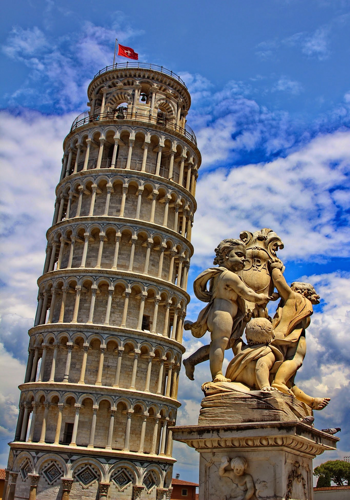

In [9]:
img_width = 350
img_height = 500
img = PIL.Image.open('pisa.jpg').resize((img_width, img_height))
img

Now we set `padding = 'same'` and try different values of `strides` for convolving the two kernels of the Sobel operator over the image. We will use the pre-defined function **sobel**.


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 54ms/step


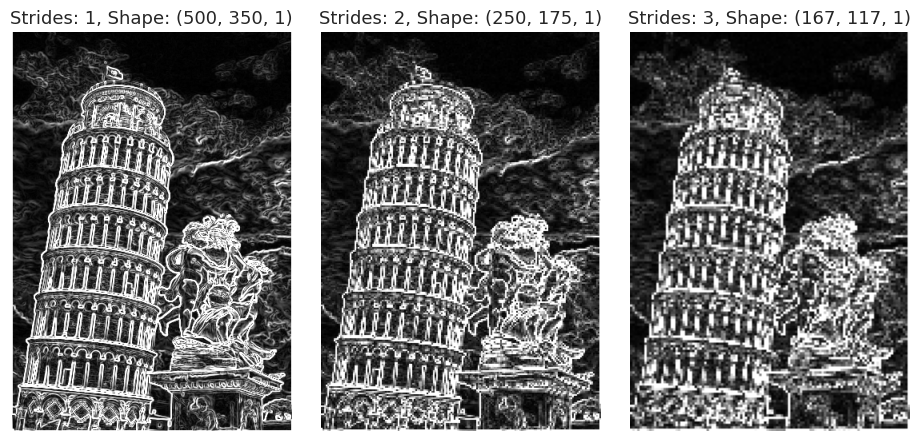

In [10]:
input_img = ImageOps.grayscale(img)
input_img = np.array(input_img).reshape((1, img_height, img_width, 1))

fig, axs = plt.subplots(1, 3, figsize=(9, 10), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.02, hspace=0, wspace=0.1)

for i, ax in enumerate(axs.flat):
    output = sobel(img = input_img, 
                   padding='same',
                   strides=i+1).astype('int').clip(0,255)

    ax.imshow(output, cmap='gray')
    ax.set_title(f"Strides: {i+1}, Shape: {output.shape}", fontsize=13)
    ax.axis('off')

As we increase the value of `strides`, the output shape becomes proportionally smaller (as shown in the image titles) but edges detected also become blurry. Therefore, whether to use stride and what value to use may be highly dependent on the specific problem at hand.


## Activation


Recall in our previous coded example or in the animated gif, the output matrix contains negative values such as -2. However, since CNN is typically implemented on images which should consist of pixels values ranging from 0 to 255, we need to make our CNN valid by adding what's called an activation after the convolution operation. 

In addition to the need of restricting certain limits for the values in our matrices, activations are also necessary for adding **non-linearity** into our network so that the network can learn complex patterns in the data.

In `tensorflow.keras.layers.Conv2D`, there is an argument called `activation` where we can specify the type of activation we want for the current convolution layer added. Currently, there are many types of activations existing, such as Sigmoid, Tanh, ReLU, ..., etc. For example, the famous **Sigmoid** function is defined as follows:

$$ f(x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{-x}}  $$ 

We can code the sigmoid function using numpy:


Text(0, 0.5, 'Sigmoid(x)')

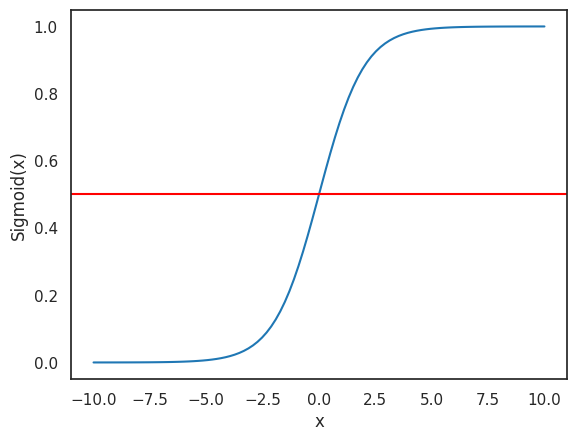

In [11]:
def sigmoid(X):

    return 1/(1 + np.exp(-X))

X = np.linspace(-10, 10, 100)
sigmoid_X = sigmoid(X)
plt.plot(X, sigmoid_X)
plt.axhline(y=0.5, color='r', linestyle='-')
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")

The sigmoid function is also called a **squashing function**. The input to the sigmoid activation is usually a weighted sum of the outputs of the previous layer. If the input is either a very large negative number or a very large positive number, the output of the activation is always between 0 and 1. 


Other than the sigmoid activation, you can also read on the different kinds of activations [here](https://en.wikipedia.org/wiki/Activation_function?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01). For this lab we will use the **ReLU** activation.

**ReLU** or **Rectified Linear Unit**, is a widely used activation function, especially with Convolutional Neural networks. It is defined as:

$$f(x) = max(0, x)$$

where x is the matrix obtained after convolution. By using ReLU, we can filter out all the negative values as they will become zero's and just keep the positive values.

We can code the relu activation using numpy:


Text(0, 0.5, 'Relu(x)')

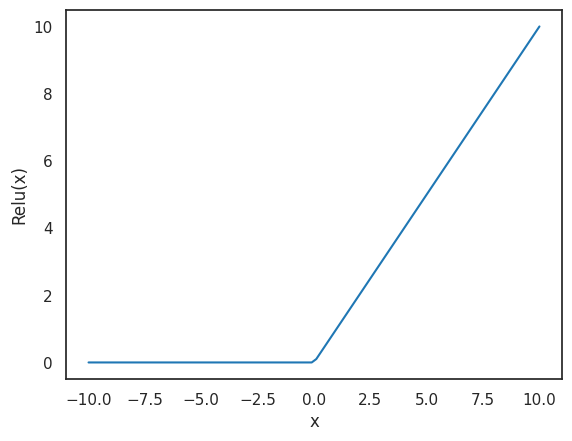

In [12]:
def relu(X):
    return np.maximum(0, X)

X = np.linspace(-10, 10, 100)
relu_X = relu(X)
plt.plot(X, relu_X)
plt.xlabel("x")

plt.ylabel("Relu(x)")

### Example 2: Feature Detection with Kernel and Activation

In this example, instead of using the Sobel operator for edge detection, we will convolve a simple kernel over all three channels of a RGB image for the same purpose. This means our final result of edge detection will no longer be a boring, grayscale image, but a colorful and exciting one!

Specifically, we will use the following kernel:

$$
	\begin{bmatrix} 
	-1 & -1 & -1 \\\\
	-1 & 8 & -1\\\\
	-1 & -1 & -1\\\\
	\end{bmatrix}
	\quad
$$

Note that the kernel we will be using contains negative values, therefore we should specify an activation function (namely **ReLu**) in our Conv2D layer to filter out the negative values.

Let's download the image first!


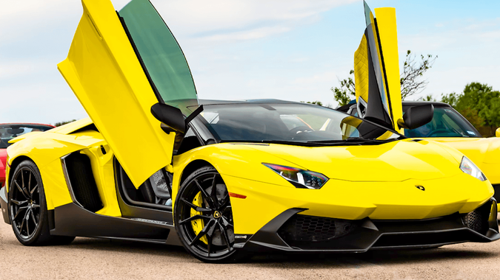

In [13]:
img_width = 500
img_height = 280

img = Image.open("car.jpeg").resize((img_width, img_height))
img

As we will be convolving the kernel over each channel, we need to split the RGB image into three channels or three grayscale images.

Let's display the three channels:


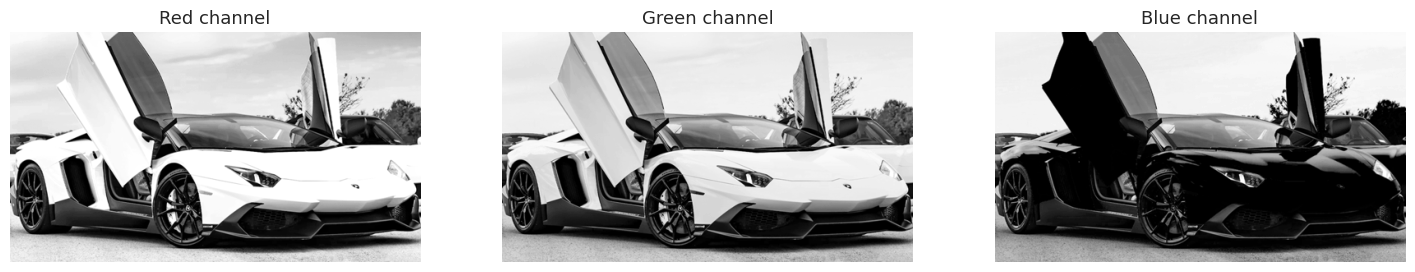

In [37]:
arr = np.array(img)
red_c = arr[:,:,0]
green_c = arr[:,:,1]
blue_c = arr[:,:,2]

channels = [red_c, green_c, blue_c]
names = ["Red", "Green", "Blue"]

plt.figure(figsize=(18, 5))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(channels[i], cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]} channel", fontsize=13)

You can see that the color of the car is mostly coming from the red and green channel, and very little from the blue channel.

Now we build a simple CNN with one Conv2D layer, using the kernel specified above as the weights.


In [40]:
kernel = np.array([[-1,-1,-1],
                   [-1,8,-1],
                   [-1,-1,-1]]).reshape(3,3,1,1)
b = np.array([0.0])

model = keras.Sequential()
model.add(layers.Conv2D(input_shape = (img_height, img_width, 1),
                 filters=1, 
                 kernel_size=3, 
                 padding='same',
                 activation='relu'
                 ))
model.set_weights([kernel, b])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 280, 500, 1)       10        
                                                                 
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


Once we initialize our CNN, we can now use it to predict the edge detection result for each of the R, G, B channel's gray image! 

Don't worry if the predicted results look almost all-black to you. Remember we used the ReLu activation to set all the negative pixel values to 0. In each channel, if the pixel value is 0, the pixel will appear black. Only the important information will be kept.


1/1 [==============================] - 0s 35ms/step


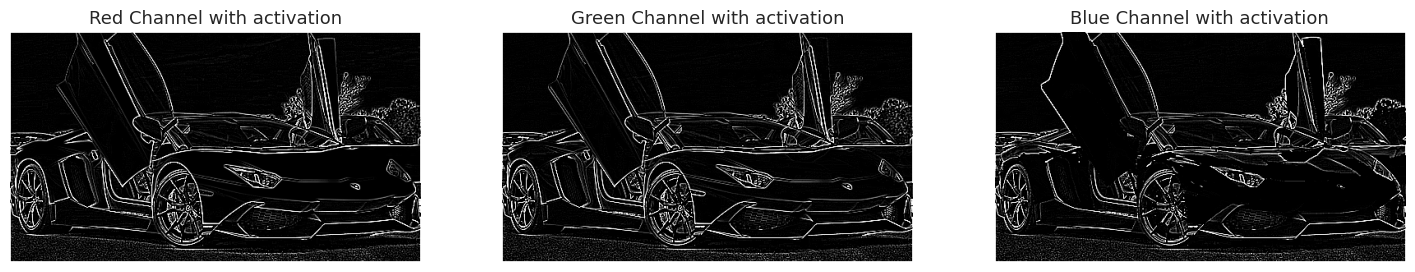

In [41]:
acts = []
plt.figure(figsize=(18,5))

for i in range(3):
    plt.subplot(1,3,i+1)
    
    # loop through each channel
    input_ = channels[i].reshape((1, img_height, img_width, 1)) 
    act = model.predict(input_).squeeze(0).squeeze(2).astype('int').clip(0,255)
    # store the result in a list called "acts"
    acts.append(act)
    
    plt.imshow(act, cmap='gray')
    plt.axis("off")
    plt.title(f"{names[i]} Channel with activation", fontsize=13)

Now it's time to stack the three channels back together and see what our edge detection tool did for us!


(-0.5, 499.5, 279.5, -0.5)

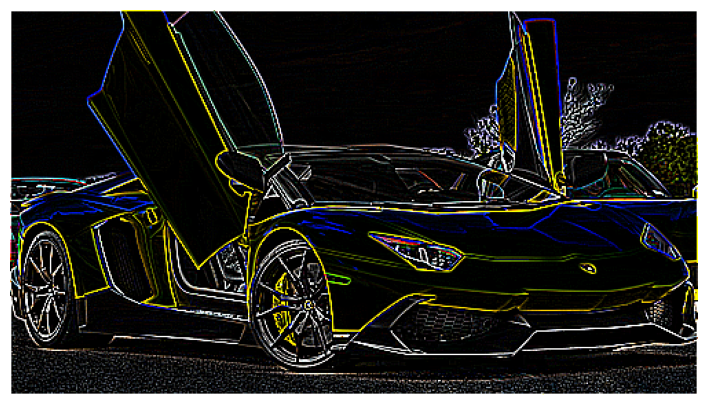

In [42]:
arr_hat = np.dstack((acts[0],acts[1],acts[2]))

plt.figure(figsize=(10,5))
plt.imshow(arr_hat)
plt.axis("off")

Since we applied the edge detector on the three color channels separately, once we merge the results after the convolutions we obtain colorful edges of the car. Each colored edge that you see in the picture above is contributed by some degree of red edges detected in channel R, green edges detected in channel G, and blue edges in channel B.


## Pooling


### What is Pooling?

A CNN model may include local and/or global pooling layers along with traditional convolutional layers. It is a form of non-linear down-sampling to progressively **reduce the spatial size of the representation**, to **reduce the number of parameters**, **memory footprint and amount of computation in the network**, and hence to also **control overfitting**.

There are two common types of pooling in popular use: **Max Pooling** and **Average Pooling**. Max pooling outputs the maximum value of each sub-region in the feature map, while average pooling outputs the average value.

It is common to periodically insert a pooling layer between successive convolutional layers (each one typically followed by an activation function, such as a ReLU layer) in a CNN architecture. You can read more about Pooling [here](https://en.wikipedia.org/wiki/Convolutional_neural_network?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML311Coursera747-2022-01-01#Pooling_layer).

An illustration of **Max Pooling**:

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/images/maxpooling.gif" width="1100"></center>


In tensorflow.keras, a **Pooling layer** downsamples the input along its spatial dimensions (height and width) by taking the maximum or average value over an input window (of size defined by `pool_size`) for each channel of the input.

You can add a Pooling layer to a CNN with **MaxPooling2D** or **AveragePooling2D**. Like a **Conv2D** layer, a Pooling layer also has arguments such as `padding` and `strides`, and they work in a same way as in a Conv2D layer. 


### Example 3: Max or Average?

- Max pooling **retains the most prominent features in the feature map**. It is useful when the background of the image is dark and we are interested in the lighter pixels of the image. For example, in the MNIST dataset, the digits are represented in white color and the background is black, so max pooling is more suitable.

- Average pooling **tends to smooth out the image**. Sometimes it cannot extract the important features because it takes everything into account, and gives an average value which may or may not be important. It shows a similar effect irrespective of the background.


Run the next cell to download the MNIST datset, which we will use to illustrate the difference between the output of Max Pooling and Average Pooling.


In [43]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
print("MNIST downloaded!")
print("Train set shape:", X_train.shape)

11490434/11490434 [==============================] - 0s 0us/step
MNIST downloaded!
Train set shape: (60000, 28, 28)


Let's extract 5 random images from the train set and display them:


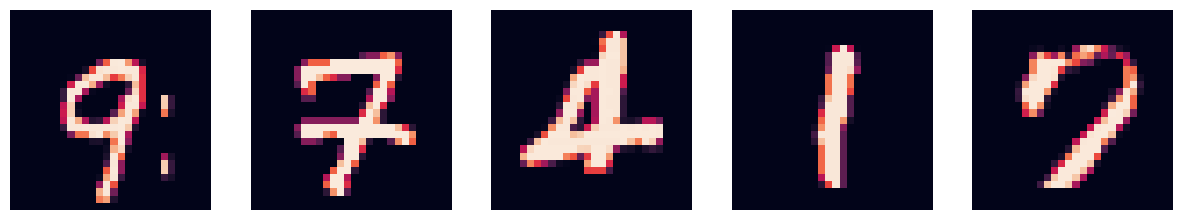

In [44]:
images = []
plt.figure(figsize=(15,3))
for i in range(5):
    img = X_train[np.random.randint(0, 60000)].astype('float')
    images.append(img)
    
    plt.subplot(1,5,i+1)
    plt.imshow(img)
    plt.axis('off')    

Next we use our **max_pool** and **avg_pool** tool to perform pooling on these five images and see how their results appear differently.


1/1 [==============================] - 0s 21ms/step


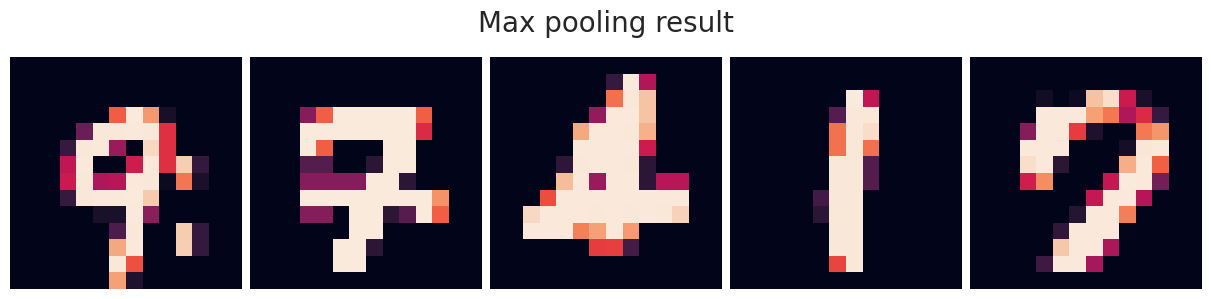

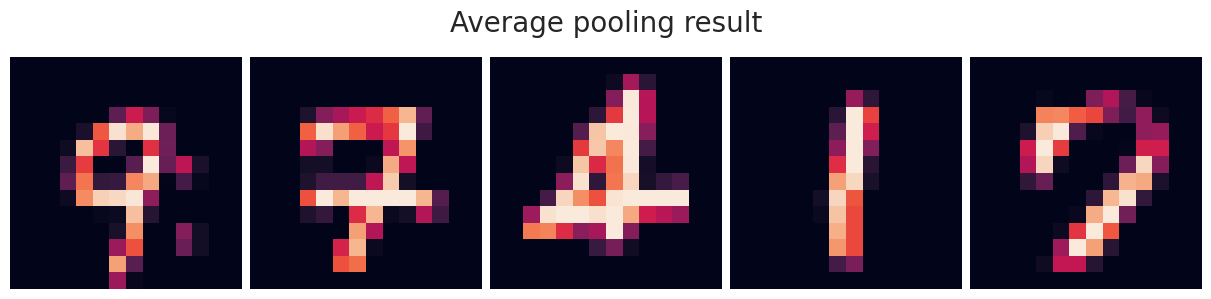

In [45]:
max_pool = keras.Sequential([MaxPooling2D(pool_size = (2,2))])
avg_pool = keras.Sequential([AveragePooling2D(pool_size = (2,2))])

fig1, axs1 = plt.subplots(1, 5, figsize=(12,3), constrained_layout=True)
fig2, axs2 = plt.subplots(1, 5, figsize=(12,3), constrained_layout=True)
fig1.suptitle("Max pooling result", fontsize=20)
fig2.suptitle("Average pooling result", fontsize=20)

for img, ax1, ax2 in zip(images, axs1.flat, axs2.flat):
    input_ = img.reshape(1, 28, 28, 1)
    ax1.imshow(max_pool.predict(input_).squeeze(0).squeeze(2))
    ax1.axis('off')
    ax2.imshow(avg_pool.predict(input_).squeeze(0).squeeze(2))
    ax2.axis('off')


As you can see, in max pooling the prominent features are highlighted more, whereas in average pooling it gives a smoother image retaining the complete features in the image.

We cannot say that one particular pooling method is better than the other generally. The choice of pooling operation should be made based on the problem at hand.


## Exercises

In this exercise, you will support building a CNN to classify images from the famous CIFAR10 dataset.

The pre-defined **load_cifar10** function will return a preprocessed cifar10 dataset, where:

1. The pixel values in **X_train** and **X_test** are normalized float numbers.
2. The **y_train** and **y_test** are one-hot encoded into 10-element binary vectors with a 1 for the index of the class value.


In [46]:
from keras.utils import to_categorical
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Sequential

def load_cifar10():
    (trainX, trainY), (testX, testY) = datasets.cifar10.load_data()
    
    trainX = trainX.astype('float32') / 255
    testX = testX.astype('float32') / 255
    
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    
    return trainX, trainY, testX, testY

In [47]:
X_train, y_train, X_test, y_test = load_cifar10()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

170498071/170498071 [==============================] - 2s 0us/step


((50000, 32, 32, 3), (50000, 10), (10000, 32, 32, 3), (10000, 10))

### Exercise 1 - Display some images

Write the code to display the first 25 images from the train set.


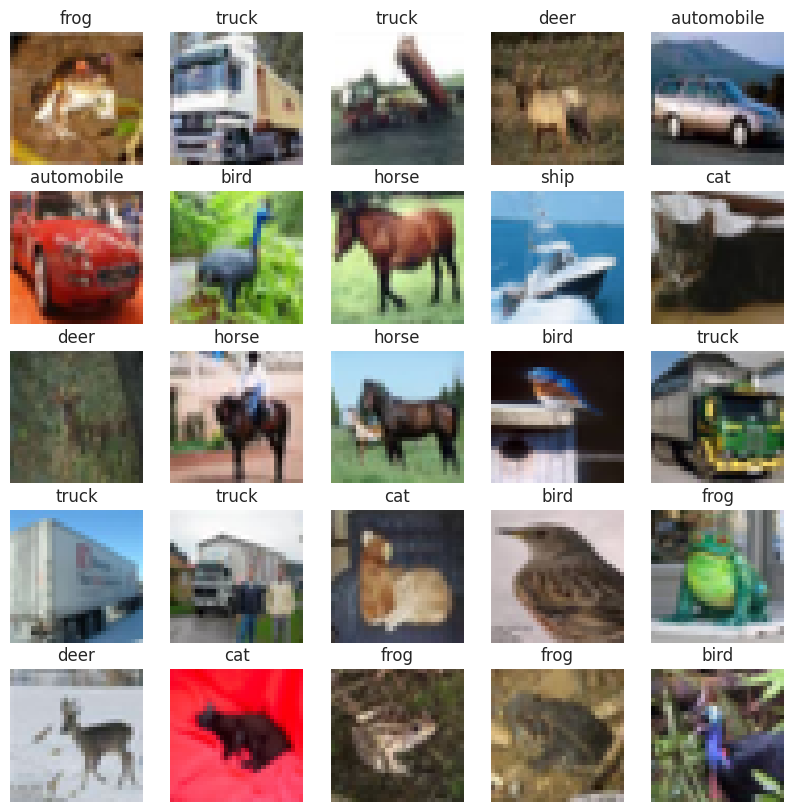

In [52]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
# TO DO
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(X_train[i])
  plt.axis('off')
  plt.title(class_names[np.where(y_train[i]==1)[0][0]])

### Exercise 2 - Set up a Convolution layer

Create a Conv2D layer called **Conv** with 
- 32 $3\times3$ kernels
- `'he_uniform'` kernel initializer
- Padding
- ReLu activation


In [53]:
# TO DO

Conv = layers.Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_uniform', padding='same', activation='relu' )

### Exercise 3 - Set up a Max pooling layer

Create a MaxPooling2D layer with pool_size equal 2, name the single layer **Max**.


In [54]:
# TO DO
Max = layers.MaxPooling2D(pool_size=(2,2))

### Exercise 4 - Create a deeper CNN with blocks

Now that you've practiced defining the two types of most commonly used layers in CNN. You can stack two **Conv** layers and one **Max** layer together as a block, and create a deeper CNN with three of those blocks!

You could choose to double the number of kernels/channels in the **Conv2D** layers as you move from one block to another.


In [59]:
# TO DO
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(32,32,3)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

### Optional section


You've accomplished a lot so far! Now just run the following cells to finish up building your CNN with some Dense layers. Don't worry if you don't know what the code does, as you will learn about Flattening and Dense layers in the next lab.


In [60]:
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='softmax'))
model.summary()
# compile model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 conv2d_26 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_27 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 conv2d_28 (Conv2D)          (None, 13, 13, 64)        36928     
                                                     

# Congratulations! - You have completed the lab
